# Majorana splitting oscillations in VG - EZ space for strong SOI

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
from scipy import optimize, sparse
import logging
import cPickle as pickle
import kwant
import dolfin
import electrostatics as estat
import generate_system
logging.getLogger('FFC').setLevel(logging.WARNING)

In [2]:
"""Set system dimensions and constants"""

hbar = 1.055e-34
m = 9.109e-31
meff = 0.014*m
akwant, aFEM = 2.5e-9, 5e-9
eV, e = 1.6023e-19, 1.6023e-19
eps0 = 8.854e-12
gamma=hbar**2/(2*meff*akwant**2)
energy_par = estat.EnergyParameters(akwant=akwant, eps_dielec=8.0, eps_wire=17.7, 
                                    gamma=hbar**2/(2*meff*akwant**2), scaler=eV/gamma, 
                                    bandgap=0.1, Delta=0.5e-3, 
                                    poisson_scale=e*aFEM**2/(akwant**3*eps0),
                                    miliscaler = 1000*gamma/eV)

dimension_par = estat.DimensionParameters(radius=50e-9/aFEM, top=250e-9/aFEM, 
                                          top_sc=187e-9/aFEM - 10*np.sin(np.pi/3.0),
                                          side=300e-9/aFEM, dielec_thickness=30e-9/aFEM, 
                                          L=1000)
solver_kwargs = {'alpha': 0.5, 'M': 5, 'verbose': 0, 'f_tol': 1e-7, 'maxiter': 200} 

Ez_range = np.arange(0e-3*eV/gamma, 4.0e-3*eV/gamma, 0.04e-3*eV/gamma)
V_G_range = np.arange(-0.94, -0.860, 0.0012)
V_SC = 0.2
l_SO = 233e-9

In [3]:
def array_derivative(dx_arr, dy_arr):
    """ Compute the derivative of one array with respect to the other """
    dx = dx_arr[1] - dx_arr[0]
    dy = np.diff(dy_arr)/dx
    dx_shifted = []
    y_shifted = []
    for i in range(len(dx_arr) - 1):
        dx_shifted.append(0.5*(dx_arr[i] + dx_arr[i + 1]))
        y_shifted.append(0.5*(dy_arr[i] + dy_arr[i + 1]))
    return np.array(y_shifted), np.array(dx_shifted), np.array(dy)

class LuInv(sparse.linalg.LinearOperator):
    def __init__(self, A):

        inst = kwant.linalg.mumps.MUMPSContext()
        inst.analyze(A, ordering='metis')
        inst.factor(A)
        self.solve = inst.solve
        sparse.linalg.LinearOperator.__init__(self, A.dtype, A.shape)

    def _matvec(self, x):
        return self.solve(x.astype(self.dtype))


def majo_splitting(mu, Ez, alpha, energy_par, dimension_par, a=2.5):
    """Compute splittings of Majorana fermions

    Parameters:
    ----------
    mu : float
        chemical potential in units of hbar^2/2 m a^2
    Ez : float
        Zeeman splitting in units of hbar^2/2 m a^2
    alpha : float
        spin-orbit splitting, alpha is 1/lso in units of a
    a : float
        lattice spacing in nanometers
    L : float
        wire length in nanometers
    energy_par: SimpleNamespace
        Namespace containing energy scales and material constants

    Returns:
    --------
    eigvals[0] : float
        Lowest eigenvalue in units of hbar^2/2ma^2
    eigvals[2] : float
        Third eigenvalue in units of hbar^2/2ma^2
    eigvals[4] : float
        Fifth eigenvalue in units of hbar^2/2ma^2
    """
    scaler = energy_par.scaler
    Delta_scaled = scaler*energy_par.Delta
    L = dimension_par.L

    sigma0 = np.array([[1, 0], [0, 1]])
    sigmax = np.array([[0, 1], [1, 0]])
    sigmay = np.array([[0, -1j], [1j, 0]])
    sigmaz = np.array([[1, 0], [0, -1]])

    lat = kwant.lattice.chain(a)
    sys = kwant.Builder()

    def wire(pos):
        x = pos[0]
        return 0.0 < x < L

    sys[lat.shape(wire, (a,))] = ((2 - mu) * np.kron(sigma0, sigmaz) + Ez *
                                  np.kron(sigmax, sigma0) + Delta_scaled *
                                  np.kron(sigma0,sigmax))
    sys[lat.neighbors()] = (-1 * np.kron(sigma0, sigmaz) +
                            1j * alpha * np.kron(sigmay, sigmaz))

    sys = sys.finalized()
    ham = sys.hamiltonian_submatrix(sparse=True)
    eigvals = abs(sparse.linalg.eigs(ham, sigma=0,
                                     k=20, OPinv=LuInv(ham))[0]).real

    return eigvals[0], eigvals[2], eigvals[4]

In [4]:
sys = generate_system.kwant_hexagonal_nanowire(energy_par, dimension_par, a=0.5)
site_pos = np.array([sys.site(i).pos for i in xrange(sys.graph.num_nodes)])
mesh, mesh_points, length, length_wire = generate_system.mesh_hexagonal_nanowire(dimension_par)[:4]
V = dolfin.FunctionSpace(mesh, 'Lagrange', 1)
discr_par = estat.DiscretizationParameters(sys=sys, site_pos=site_pos, mesh=mesh, 
                                           mesh_points=mesh_points, length=length, 
                                           length_wire=length_wire, V=V)

majo_coupling_matrix = []
mu_matrix = []
initial_guess = 0.06*np.ones(discr_par.length)

for V_G in V_G_range:
    sigma = estat.energy_lowerbound(V_G, V_SC, energy_par)
    perturbations, mu0, modes, n, sp_sol, energies = \
    estat.init_field_simulation(energy_par.scaler*3.5e-3, initial_guess, sigma, 
                                l_SO, V_G, V_SC, generate_system.potential, 
                                solver_kwargs, energy_par, dimension_par, 
                                discr_par)[:6]
    print 'loop for V_G =', V_G, 'started'
    dmu_init = np.zeros(len(energies))
    initial_guess = sp_sol
    majo_coupling_list = []
    mu_list = []
    
    for Ez in Ez_range:
        mu_pert = estat.self_consistent_mu(modes, energies, n, perturbations,\
                                        Ez, l_SO, dmu_init, V_G, energy_par)[0]
        dmu_init = mu_pert
        mu = mu0 - mu_pert[-1]
        majo_energy = majo_splitting(mu, Ez, akwant/l_SO, 
                                     energy_par, dimension_par)[0]
        majo_coupling_list.append(energy_par.miliscaler*majo_energy)
        mu_list.append(energy_par.miliscaler*mu)
    majo_coupling_matrix.append(majo_coupling_list)
    mu_matrix.append(mu_list)
    

loop for V_G = -0.8608 started


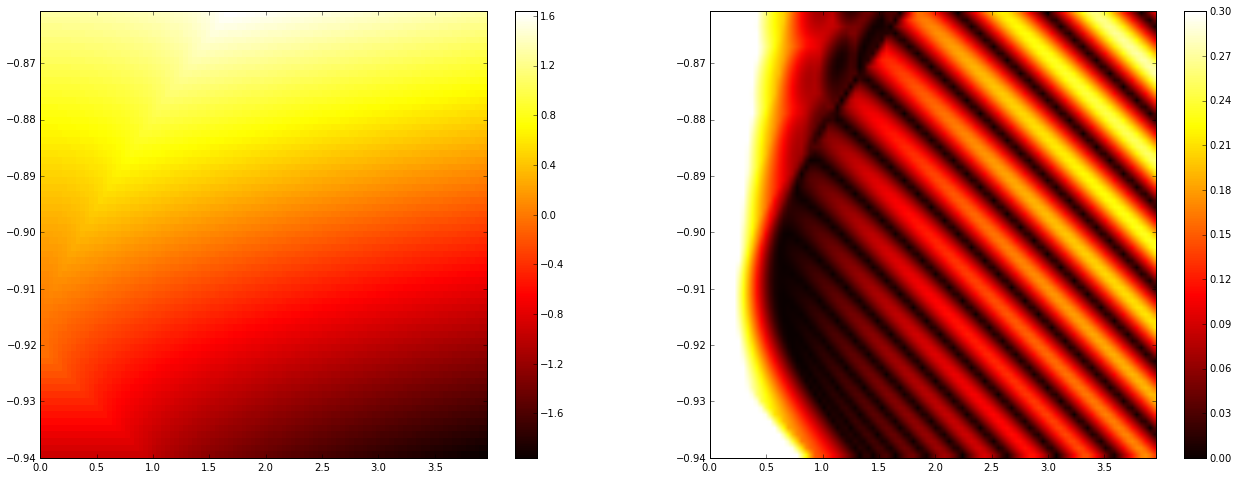

In [6]:
Ez_range_scaled = 1000*gamma/eV*Ez_range
x0 = Ez_range_scaled[0]
x1 = Ez_range_scaled[-1]
y0 = V_G_range[0]
y1 = V_G_range[-1]

fig = plt.figure(figsize=(22,8))
ax1 = plt.subplot(121)
im = ax1.imshow(mu_matrix, cmap=plt.get_cmap('hot'), interpolation='nearest', 
                extent=[x0, x1, y0, y1], aspect='auto', origin='lower')
fig.colorbar(im)

ax2 = plt.subplot(122)
im = ax2.imshow(majo_coupling_matrix, cmap=plt.get_cmap('hot'), 
                interpolation='bilinear', extent=[x0, x1, y0, y1], 
                aspect='auto',origin='lower', vmax=0.3)
fig.colorbar(im)
plt.show()

In [12]:
with open("data_majo_osc_SO233nm.p", 'wb') as fp:
    pickle.dump(majo_coupling_matrix, fp)
    pickle.dump(Ez_range_scaled, fp)
    pickle.dump(V_G_range, fp)